Libraries

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import time  # Add this at the top of your code
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random
from copy import deepcopy as dc

Initial Values

In [ ]:
N = 8  # Total number of aid recipients (bu UAV)
L = 5  # Number of aid recipients accessible by truck
R = 1  # Number of Trucks
V = 1  # Number of UAVs
q = 2  # Relief item capacity limit of UAVs. (unlimited)
#M = 10000  # A large number


A_T = (list(range(L+1)))+[N+1]  # Set of nodes for trucks
A_U = list(range(N+2))# Set of nodes for UAVs

T = list(range(1,R+1))      # Set of trucks
U = T

# Number of nodes
N += 1

Plots & Distance Matrices

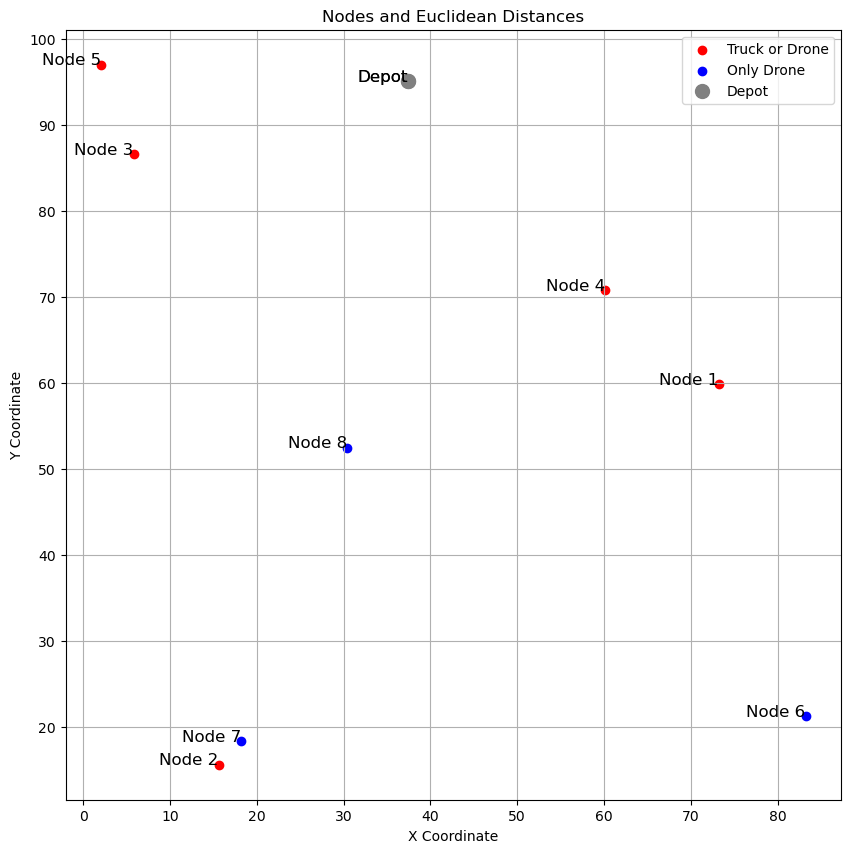

In [227]:
np.random.seed(42)  # For reproducibility
coordinates = np.random.rand(N, 2) * 100  # Generate random coordinates in a 100x100 area

coordinates = np.vstack([coordinates, coordinates[0]])


euclidean_dist_matrix = distance_matrix(coordinates, coordinates)
manhattan_dist_matrix = distance_matrix(coordinates, coordinates, p=1)

euclidean_df = pd.DataFrame(euclidean_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])
manhattan_df = pd.DataFrame(manhattan_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])

plt.figure(figsize=(10, 10))
# plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')
plt.scatter(coordinates[A_T[1:-1], 0], coordinates[A_T[1:-1], 1], color='red', label='Truck or Drone')
plt.scatter(coordinates[[item for item in A_U if item not in A_T], 0], coordinates[[item for item in A_U if item not in A_T], 1], color='blue', label='Only Drone')

# Highlight the first and last points as depots
plt.scatter(coordinates[0, 0], coordinates[0, 1], color='gray', s=100, label='Depot')
plt.scatter(coordinates[-1, 0], coordinates[-1, 1], color='gray', s=100)

# Annotate the nodes
for i, (x, y) in enumerate(coordinates):
    if i == 0:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    elif i == len(coordinates) - 1:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    else:
        plt.text(x, y, f'Node {i}', fontsize=12, ha='right')

# Draw lines between nodes for Euclidean distances
#for i in range(len(coordinates)):
 #   for j in range(i + 1, N+1):
  #      plt.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Nodes and Euclidean Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()


d_t = manhattan_df  # Travel times for trucks => will change into a matrix of Manhttan distances
d_u = euclidean_df  # Travel times for UAVs => will change into a matrix of  Euclidean distances


Finalized functions

In [438]:
def random_truck_sol(nodes):
    selected_nodes = random.sample(nodes[1:-1], k=random.randint(1, len(nodes[1:-1])))
    random.shuffle(selected_nodes)
    final_nodes = [nodes[0]] + selected_nodes + [nodes[-1]]  # Ensure first and last nodes remain
    return final_nodes


# def random_uav_sol(uav, truck, q):
#     UAV_only = [x for x in uav if x not in truck]
#     random.shuffle(UAV_only)
#     x = random.sample(truck[:-1], np.random.randint(1,len(truck)))
#     # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
#     a_chunks = []
#     i = 0
#     while i < len(UAV_only):
#         chunk_size = random.randint(1, q)  # Random size between 1 and q
#         a_chunks.append(UAV_only[i:i+chunk_size])
#         i += chunk_size
#     while len(a_chunks) > len(x) + 1:
#         x.append(0)
#     while len(a_chunks) < len(x):
#         x = random.sample(x, np.random.randint(1,len(a_chunks)))
#     random.shuffle(x)
#     # print(x)
#     a_chunks,x
#     final_uav = [0]
#     for i in range(len(x)):
#         final_uav += a_chunks[i]
#         final_uav.append(x[i])
#     final_uav += a_chunks[-1]
#     final_uav.append(truck[-1])
#     return final_uav


def random_uav_sol(uav, truck, q):
    UAV_only = [x for x in uav if x not in truck]
    random.shuffle(UAV_only)
    indices = sorted(random.sample(range(len(truck) - 1), np.random.randint(1, len(truck))))
    x = [truck[i] for i in indices]
    # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
    a_chunks = []
    i = 0
    while i < len(UAV_only):
        chunk_size = random.randint(1, q)  # Random size between 1 and q
        a_chunks.append(UAV_only[i:i+chunk_size])
        i += chunk_size
    while len(a_chunks) > len(x) + 1:
        x.insert(random.randrange(len(x)+1), 0)
    while len(a_chunks) <= len(x):
        x.pop(random.randrange(len(x)))
    final_uav = [0]
    for i in range(len(x)):
        final_uav += a_chunks[i]
        final_uav.append(x[i])
    final_uav += a_chunks[-1]
    final_uav.append(truck[-1])
    return final_uav

# def random_uav_sol_CO(uav, truck, q):
#     UAV_only = [x for x in uav if x not in truck]
#     # random.shuffle(UAV_only)
#     x = random.sample(truck[:-1], np.random.randint(1,len(truck)))
#     # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
#     a_chunks = []
#     i = 0
#     while i < len(UAV_only):
#         chunk_size = random.randint(1, q)  # Random size between 1 and q
#         a_chunks.append(UAV_only[i:i+chunk_size])
#         i += chunk_size
#     while len(a_chunks) > len(x) + 1:
#         x.append(0)
#     while len(a_chunks) < len(x):
#         x = random.sample(x, np.random.randint(1,len(a_chunks)))
#     random.shuffle(x)
#     a_chunks,x
#     final_uav = [0]
#     for i in range(len(x)):
#         final_uav += a_chunks[i]
#         final_uav.append(x[i])
#     final_uav += a_chunks[-1]
#     final_uav.append(truck[-1])
#     return final_uav

def random_uav_sol_CO(uav, truck, q):
    UAV_only = [x for x in uav if x not in truck]
    # random.shuffle(UAV_only)
    indices = sorted(random.sample(range(len(truck) - 1), np.random.randint(1, len(truck))))
    x = [truck[i] for i in indices]
    # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
    a_chunks = []
    i = 0
    while i < len(UAV_only):
        chunk_size = random.randint(1, q)  # Random size between 1 and q
        a_chunks.append(UAV_only[i:i+chunk_size])
        i += chunk_size
    while len(a_chunks) > len(x) + 1:
        x.insert(random.randrange(len(x)+1), 0)
    while len(a_chunks) <= len(x):
        x.pop(random.randrange(len(x)))
    final_uav = [0]
    for i in range(len(x)):
        final_uav += a_chunks[i]
        final_uav.append(x[i])
    final_uav += a_chunks[-1]
    final_uav.append(truck[-1])
    return final_uav

def population(truck_nodes, uav_nodes, q, pop_size):
    temp = []
    for i in range(pop_size):
        random_tr = random_truck_sol(truck_nodes)
        random_uav = random_uav_sol(allnodes,random_tr, q)
        temp.append([random_tr,random_uav])
    return temp

def cleaner(parent):
    return parent[0][1:-1] + [x for x in parent[1] if x not in parent[0]]

def crossover(p1,p2):
    flag = True
    i = 0
    parent1 = cleaner(p1)
    parent2 = cleaner(p2)
    while flag == True and i < 20:
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        i += 1
        if len(set(child1)) == len(child1) :
            flag = False
            return child1, child2
        elif i == 19:
            return parent1,parent2

def remaker(child,UAV_only,truck,q):
    i = 0
    while child[i] not in UAV_only:
        i += 1
    new_truck = [0]+ child[:i]+[truck[-1]]
    return [new_truck,random_uav_sol_CO(child[i:], new_truck, q)]


def makespan(route, d_t, d_u):
    """
    Calculate the final synchronized arrival times for two vehicles given their routes
    and travel time dataframes.
    
    Parameters:
        route1 (list): List of node IDs for vehicle 1 (including start and end).
        route2 (list): List of node IDs for vehicle 2 (including start and end).
        d_t (pd.DataFrame): Travel time matrix for vehicle 1. Rows and columns are node IDs.
        d_u (pd.DataFrame): Travel time matrix for vehicle 2. Rows and columns are node IDs.
        
    Returns:
        tuple: (final_time_vehicle1, final_time_vehicle2)
        
    Notes:
      - The last node in each route is ignored (i.e. only the nodes route[:-1] are used).
      - For any common node (other than 0) that appears in both routes, the vehicle that arrives
        earlier will wait until the other vehicle has reached that node. The waiting delay is added 
        to all subsequent travel.
    """
    route1, route2 = route[0],route[1]
    # Exclude the last node from each route
    route1_eff = route1[:-1]
    route2_eff = route2[:-1]
    # Compute raw arrival times for vehicle 1 using d_t
    times1 = [0.0]
    for i in range(len(route1_eff) - 1):
        current_node = route1_eff[i]
        next_node = route1_eff[i + 1]
        travel_time = d_t.iloc[current_node, next_node]
        times1.append(times1[-1] + travel_time)

    # Compute raw arrival times for vehicle 2 using d_u
    times2 = [0.0]
    for i in range(len(route2_eff) - 1):
        current_node = route2_eff[i]
        next_node = route2_eff[i + 1]
        travel_time = d_u.iloc[current_node, next_node]
        times2.append(times2[-1] + travel_time)
    # Identify common nodes (excluding node 0)
    common_nodes = set(route1_eff).intersection(set(route2_eff)) - {0}
    # Process common nodes in the order of their first occurrence in route1
    common_nodes_ordered = sorted(common_nodes, key=lambda n: route1_eff.index(n))

    # Synchronize arrival times at each common node
    for node in common_nodes_ordered:
        idx1 = route1_eff.index(node)
        idx2 = route2_eff.index(node)
        # The synchronized time is the maximum of both arrival times at the common node
        sync_time = max(times1[idx1], times2[idx2])
        
        # If vehicle 1 arrives earlier, add the delay to all subsequent times
        if times1[idx1] < sync_time:
            delay = sync_time - times1[idx1]
            for j in range(idx1 + 1, len(times1)):
                times1[j] += delay
        
        # If vehicle 2 arrives earlier, add the delay to all subsequent times
        if times2[idx2] < sync_time:
            delay = sync_time - times2[idx2]
            for j in range(idx2 + 1, len(times2)):
                times2[j] += delay

    return times1[-1], times2[-1]


Under test

In [470]:
nodes = [0,1,2,3,9]
allnodes = [0,1,2,3,4,5,6,7,8,9]
q = 2
pop_size = 1000
truck_nodes = random_truck_sol(nodes)
uav_nodes = random_uav_sol(allnodes, truck_nodes, q)
pop = population(truck_nodes, uav_nodes, q, pop_size)
UAV_only = [x for x in allnodes if x not in nodes]

In [444]:
# pop 

# crossover(p1,p2)

[[[0, 2, 9], [0, 8, 5, 0, 6, 7, 0, 4, 0, 1, 2, 3, 9]],
 [[0, 1, 9], [0, 3, 1, 5, 7, 0, 2, 8, 0, 4, 0, 6, 9]],
 [[0, 1, 2, 9], [0, 6, 0, 4, 5, 0, 8, 3, 0, 7, 9]],
 [[0, 1, 9], [0, 3, 6, 0, 7, 5, 0, 4, 2, 0, 8, 9]],
 [[0, 1, 9], [0, 8, 2, 0, 7, 1, 6, 5, 0, 3, 0, 4, 9]],
 [[0, 2, 9], [0, 1, 5, 0, 4, 7, 0, 6, 2, 8, 3, 9]],
 [[0, 1, 2, 9], [0, 8, 7, 0, 6, 3, 0, 4, 5, 9]],
 [[0, 1, 2, 9], [0, 3, 4, 0, 5, 7, 1, 6, 2, 8, 9]],
 [[0, 2, 9], [0, 5, 0, 6, 0, 7, 0, 4, 3, 2, 1, 0, 8, 9]],
 [[0, 2, 9], [0, 5, 8, 0, 1, 0, 3, 6, 0, 4, 0, 7, 9]],
 [[0, 1, 9], [0, 5, 0, 6, 0, 7, 8, 0, 4, 2, 0, 3, 9]],
 [[0, 1, 9], [0, 7, 0, 5, 0, 4, 3, 0, 2, 6, 1, 8, 9]],
 [[0, 2, 1, 9], [0, 6, 0, 3, 4, 0, 7, 5, 1, 8, 9]],
 [[0, 1, 2, 9], [0, 8, 0, 7, 2, 6, 0, 3, 0, 4, 5, 9]],
 [[0, 2, 9], [0, 1, 6, 0, 5, 7, 0, 4, 3, 2, 8, 9]],
 [[0, 1, 9], [0, 8, 5, 0, 7, 0, 6, 0, 4, 0, 3, 1, 2, 9]],
 [[0, 1, 9], [0, 3, 4, 0, 8, 0, 5, 0, 6, 1, 7, 2, 9]],
 [[0, 1, 2, 9], [0, 7, 4, 0, 6, 8, 1, 3, 2, 5, 9]],
 [[0, 2, 9], [0, 3, 0, 6, 1, 0,

In [390]:
# my_list = [4,3,2,6,8,7,2]
# for i in range(10):
#     my_list = [4,3,2,6,8,7,2]
#     my_list.insert(random.randrange(len(my_list)+1), 0)
#     print(my_list)

[4, 0, 3, 2, 6, 8, 7, 2]
[4, 3, 2, 0, 6, 8, 7, 2]
[4, 3, 0, 2, 6, 8, 7, 2]
[4, 3, 2, 6, 8, 7, 2, 0]
[4, 3, 2, 6, 8, 7, 0, 2]
[4, 3, 2, 6, 8, 7, 2, 0]
[4, 3, 0, 2, 6, 8, 7, 2]
[4, 3, 2, 6, 8, 0, 7, 2]
[0, 4, 3, 2, 6, 8, 7, 2]
[4, 0, 3, 2, 6, 8, 7, 2]


In [368]:
# truck = [0,1,2,3,9]
# for i in range(10):
#     indices = sorted(random.sample(range(len(truck) - 1), np.random.randint(1, len(truck))))
#     x = [truck[i] for i in indices]
#     print(x)

[0, 1, 2, 3]
[1, 2, 3]
[0, 2, 3]
[1, 3]
[0, 1, 2]
[2, 3]
[1, 2]
[0, 3]
[0, 1]
[0, 3]


In [211]:
population(truck_nodes, uav_nodes, q, pop_size=5)

[[[0, 3, 2, 1, 9], [0, 4, 5, 2, 8, 7, 3, 6, 9]],
 [[0, 3, 1, 9], [0, 5, 8, 0, 7, 6, 0, 2, 4, 9]],
 [[0, 2, 1, 9], [0, 4, 0, 8, 1, 7, 3, 0, 6, 0, 5, 9]],
 [[0, 3, 1, 2, 9], [0, 8, 0, 7, 1, 6, 4, 2, 5, 9]],
 [[0, 2, 1, 9], [0, 3, 4, 0, 8, 7, 0, 5, 6, 9]]]

In [408]:

# def random_uav_sol(uav, truck, q):
#     UAV_only = [x for x in uav if x not in truck]
#     random.shuffle(UAV_only)
#     indices = sorted(random.sample(range(len(truck) - 1), np.random.randint(1, len(truck))))
#     x = [truck[i] for i in indices]
#     # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
#     a_chunks = []
#     i = 0
#     while i < len(UAV_only):
#         chunk_size = random.randint(1, q)  # Random size between 1 and q
#         a_chunks.append(UAV_only[i:i+chunk_size])
#         i += chunk_size
#     while len(a_chunks) > len(x) + 1:
#         x.insert(random.randrange(len(x)+1), 0)
#     while len(a_chunks) <= len(x):
#         x.pop(random.randrange(len(x)))
#     final_uav = [0]
#     for i in range(len(x)):
#         final_uav += a_chunks[i]
#         final_uav.append(x[i])
#     final_uav += a_chunks[-1]
#     final_uav.append(truck[-1])
#     return final_uav

# # uav = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# # truck = [0,1,2,3,9]
# # for i in range(10):
# # # random_truck_sol(truck), 
# #     print(random_uav_sol(uav, truck, q))
# # # random.sample(truck[:-1], np.random.randint(1,len(truck)))

In [464]:
# for ele in pop:
#     v = [x for x in ele[1] if x != 0]
#     # print(len(set(v)))
#     if len(set(v)) == len(v):
#         # print('yes')
#         pass
#     else:
#         print(v)
# # pop[:30]


In [141]:
d_t.iloc[0,2]+d_t.iloc[2,1]+d_t.iloc[1,3],  d_u.iloc[0,4]+d_u.iloc[4,1],  d_t.iloc[0,2]+d_t.iloc[2,1]+d_u.iloc[1,5]+d_u.iloc[5,7]+d_u.iloc[7,2]


(297.3308520929546, 50.257009292922554, 367.4843422791239)

In [468]:
# cleaner(p1),cleaner(p2)
for i in range(5):
    # p1,p2 = random.sample(pop, 2)
    p1,p2 = pop[1],pop[2]
    print(p1)
    print(makespan(p1, d_t, d_u))

    print(p2)
    print(makespan(p2, d_t, d_u))

    # print(i,crossover(p1,p2))
    child1,child2 = crossover(p1,p2)
    print(child1,child2)
    print()
    c1, c2 = remaker(child1,UAV_only,nodes,q), remaker(child2,UAV_only,nodes,q)
    print(c1)
    print(c2)
    print(makespan(c1, d_t, d_u))
    print(makespan(c2, d_t, d_u))
    print()
    print('next')

[[0, 3, 9], [0, 7, 0, 5, 0, 1, 6, 3, 2, 0, 8, 4, 9]]
(40.09946673141441, 652.7335545013923)
[[0, 3, 9], [0, 6, 2, 0, 5, 4, 0, 8, 1, 3, 7, 9]]
(40.09946673141441, 597.9888546704273)
[3, 6, 2, 5, 4, 8, 1, 7] [3, 7, 5, 1, 6, 2, 8, 4]

[[0, 3, 9], [0, 6, 0, 2, 0, 5, 4, 0, 8, 1, 0, 7, 9]]
[[0, 3, 9], [0, 7, 5, 0, 1, 0, 6, 0, 2, 0, 8, 0, 4, 9]]
(40.09946673141441, 686.8065490246197)
(40.09946673141441, 753.3425886232455)

next
[[0, 3, 9], [0, 7, 0, 5, 0, 1, 6, 3, 2, 0, 8, 4, 9]]
(40.09946673141441, 652.7335545013923)
[[0, 3, 9], [0, 6, 2, 0, 5, 4, 0, 8, 1, 3, 7, 9]]
(40.09946673141441, 597.9888546704273)
[3, 6, 2, 5, 4, 8, 1, 7] [3, 7, 5, 1, 6, 2, 8, 4]

[[0, 3, 9], [0, 6, 2, 0, 5, 4, 0, 8, 1, 0, 7, 9]]
[[0, 3, 9], [0, 7, 5, 0, 1, 0, 6, 2, 3, 8, 0, 4, 9]]
(40.09946673141441, 585.378255731502)
(40.09946673141441, 640.1015833293935)

next
[[0, 3, 9], [0, 7, 0, 5, 0, 1, 6, 3, 2, 0, 8, 4, 9]]
(40.09946673141441, 652.7335545013923)
[[0, 3, 9], [0, 6, 2, 0, 5, 4, 0, 8, 1, 3, 7, 9]]
(40.09946673141

In [ ]:

# def uav_distance(route):
#     return sum(d_u[route[i], route[i + 1]] for i in range(len(route) - 1))

# def latest_node_visited(truck_route, uav_route):
    return max(truck_distance(truck_route[:-1]), uav_distance(uav_route[:-1]))

In [ ]:

# def generate_solution(truck_nodes):
#     truck_route = random.sample(truck_nodes, len(truck_nodes))
#     uav_visits = {}
#     for node in truck_route:
#         uav_path = [n for n in range(num_nodes) if n not in truck_nodes and random.random() > 0.5]
#         uav_path = uav_path[:q]  # Enforce UAV visit limit
#         uav_visits[node] = uav_path
#     return truck_route, uav_visits

# def random_truck_sol(nodes):
#     # Select between 1 and len(nodes[1:-1]) elements
#     selected_nodes = random.sample(nodes[1:-1], k=random.randint(1, len(nodes[1:-1])))
#     random.shuffle(selected_nodes)
#     final_nodes = [nodes[0]] + selected_nodes + [nodes[-1]]  # Ensure first and last nodes remain
#     return final_nodes

def random_uav_sol(truck_nodes, c, q):
    # bn a if x not in b]
    b = dc(c)
    b.pop()
    # Step 1: Randomly shuffle list a
    a_shuffled = a.copy()
    a_shuffled = a_shuffled
    random.shuffle(a_shuffled)
    
    # Step 2: Partition 'a' into random-sized chunks (size 1 to q)
    a_chunks = []
    i = 0
    while i < len(a_shuffled):
        chunk_size = random.randint(1, q)  # Random size between 1 and q
        a_chunks.append(a_shuffled[i:i+chunk_size])
        i += chunk_size
    # print('a_chunks',a_chunks)
    # Step 3: Interleave elements of b into a_chunks
    result = []
    b_index = 0
    for i in range(len(a_chunks)):
        result.extend(a_chunks[i])  # Add the chunk of 'a'
        # Add an element from b if available; otherwise, add 0
        if i == (len(a_chunks)-1):
            break
        elif b_index < len(b)-1:
            result.append(b[b_index+1])
            b_index += 1
        else:
            result.append(0)

    return [0] + result + [c[-1]]

def population(truck_nodes, uav_nodes, q, num_geration):
    temp = []
    for i in range(num_geration):
        random_tr = random_truck_sol(truck_nodes)
        uav_rem = [x for x in uav_nodes if x not in random_tr]
        temp.append([random_tr,random_uav_sol(uav_rem,random_tr,q)])
    return temp



# Objective Functions
# def truck_distance(route):
#     return sum(d_t[route[i], route[i + 1]] for i in range(len(route) - 1))

# def uav_distance(route):
#     return sum(d_u[route[i], route[i + 1]] for i in range(len(route) - 1))

# def latest_node_visited(truck_route, uav_route):
    return max(truck_distance(truck_route[:-1]), uav_distance(uav_route[:-1]))

# Generate Random Solution
def random_truck_sol(nodes):
    selected_nodes = random.sample(nodes[1:-1], k=random.randint(1, len(nodes[1:-1])))
    random.shuffle(selected_nodes)
    return [nodes[0]] + selected_nodes + [nodes[-1]]

def random_uav_sol(a, c, q):
    b = dc(c)
    b.pop()
    a_shuffled = a.copy()
    random.shuffle(a_shuffled)
    a_chunks, i = [], 0
    while i < len(a_shuffled):
        chunk_size = random.randint(1, q)
        a_chunks.append(a_shuffled[i:i+chunk_size])
        i += chunk_size
    result, b_index = [], 0
    for chunk in a_chunks:
        result.extend(chunk)
        if b_index < len(b) - 1:
            result.append(b[b_index + 1])
            b_index += 1
        else:
            result.append(0)
    return [0] + result + [c[-1]]



"------------ genetic algorithm -------------"

def generate_population(truck_nodes, uav_nodes, q, size):
    population = []
    for _ in range(size):
        truck_route = random_truck_sol(truck_nodes)
        uav_rem = [x for x in uav_nodes if x not in truck_route]
        uav_route = random_uav_sol(uav_rem, truck_route, q)
        population.append([truck_route, uav_route])
    return population

# NSGA-II Functions
def dominates(obj1, obj2):
    return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

def non_dominated_sort(population):
    fronts = [[]]
    S, n, rank = {}, {}, {}
    for p in range(len(population)):
        S[p], n[p] = [], 0
        for q in range(len(population)):
            if dominates(population[p][2], population[q][2]):
                S[p].append(q)
            elif dominates(population[q][2], population[p][2]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    return fronts[:-1]




'here needs update'
def evaluate_population(population):
    evaluated = []
    for truck_route, uav_route in population:
        dist = truck_distance(truck_route) + uav_distance(uav_route)
        latest = latest_node_visited(truck_route, uav_route)
        evaluated.append((truck_route, uav_route, [dist, latest]))
    return evaluated
'here needs update'



# Main NSGA-II
def nsga2(truck_nodes, uav_nodes, q, pop_size=100, generations=50):
    population = generate_population(truck_nodes, uav_nodes, q, pop_size)
    solutions = evaluate_population(population)

    for gen in range(generations):
        # print(f"Generation {gen+1}")
        fronts = non_dominated_sort(solutions)
        new_population = []
        
        for front in fronts:
            if len(new_population) + len(front) <= pop_size:
                new_population.extend([solutions[i] for i in front])
            else:
                break
        
        # Mutation for the next generation
        population = generate_population(truck_nodes, uav_nodes, q, pop_size)
        solutions = evaluate_population(population)
    
    return solutions, fronts


def minimize_node_difference(truck_route, uav_route):
    """Minimize the difference between the latest and first visited nodes (excluding first/last truck nodes)."""
    truck_inner = truck_route[1:-1]  # Exclude first and last nodes
    uav_inner = uav_route[1:-1]  # Exclude first and last nodes
    
    truck_diff = abs(max(truck_inner) - min(truck_inner)) if truck_inner else 0
    uav_diff = abs(max(uav_inner) - min(uav_inner)) if uav_inner else 0

    return min(truck_diff, uav_diff)

def crossover(parent1,parent2):
    of1 = [0,0,0]
    while len(of1) != len(set(of1)) or len(of2) != len(set(of2)):        
        id1 = np.random.randint(1,len(parent1)-1)
        id2 = np.random.randint(1,len(parent2)-1)
        of1 = parent1[:id1] + parent2[id2:]
        of2 = parent2[:id2] + parent1[id1:]
    return of1,of2

"------------ here is the pareto front section -------------"

def dominates(solution1, solution2):
    return all(x <= y for x, y in zip(solution1, solution2)) and any(x < y for x, y in zip(solution1, solution2))

def find_pareto_front(solutions):
    pareto_front = []
    for solution in solutions:
        # Check if the solution is dominated by any in the current Pareto front
        is_dominated = False
        for other in pareto_front:
            if dominates(other, solution):
                is_dominated = True
                break
        # Remove dominated solutions already in the Pareto front
        pareto_front = [other for other in pareto_front if not dominates(solution, other)]
        # Add the current solution if it is not dominated
        if not is_dominated:
            pareto_front.append(solution)
    return pareto_front



def calculate_visit_times(route, distance_matrix):
    visit_times = {route[0]: 0}  # Start at time 0 for the first node
    for i in range(1, len(route)):
        visit_times[route[i]] = visit_times[route[i - 1]] + distance_matrix[route[i - 1], route[i]]
    return visit_times

def synchronize_visit_times(truck_times, uav_times, truck_route, uav_route):
    for node in set(truck_route[1:-1]) & set(uav_route[1:-1]):  # Exclude first and last nodes
        max_time = max(truck_times[node], uav_times[node])
        truck_times[node] = max_time
        uav_times[node] = max_time


In [ ]:
def min_by_first_value(data):
    return min(data, key=lambda x: x[2][0])

def min_by_second_value(data):
    return min(data, key=lambda x: x[2][1])
    

def min_by_sum_of_values(data):
    return min(data, key=lambda x: x[2][0] + x[2][1])

# Compute the results
result_first = min_by_first_value(solutions)
result_second = min_by_second_value(solutions)
result_sum = min_by_sum_of_values(solutions)

# Display the results
print("Minimum by first value:", result_first)
print("Minimum by second value:", result_second)
print("Minimum by sum of values:", result_sum)

In [ ]:
N = 8  # Total number of aid recipients (bu UAV)
L = 5  # Number of aid recipients accessible by truck
R = 1  # Number of Trucks
V = 1  # Number of UAVs
q = 2  # Relief item capacity limit of UAVs. (unlimited)

A_T = (list(range(L+1)))+[N+1]  # Set of nodes for trucks
A_U = list(range(N+2))# Set of nodes for UAVs

T = list(range(1,R+1))      # Set of trucks
U = T

# Number of nodes
N += 1

np.random.seed(42)  # For reproducibility
coordinates = np.random.rand(N, 2) * 100  # Generate random coordinates in a 100x100 area

coordinates = np.vstack([coordinates, coordinates[0]])


euclidean_dist_matrix = distance_matrix(coordinates, coordinates)
manhattan_dist_matrix = distance_matrix(coordinates, coordinates, p=1)

euclidean_df = pd.DataFrame(euclidean_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])
manhattan_df = pd.DataFrame(manhattan_dist_matrix, columns=[f'Node {i}' for i in range(N+1)], index=[f'Node {i}' for i in range(N+1)])


# Truck and UAV nodes
truck_nodes = A_T
uav_nodes = A_U
q = 2  # UAV max consecutive nodes


d_t = manhattan_df  # Travel times for trucks => will change into a matrix of Manhttan distances
d_u = euclidean_df  # Travel times for UAVs => will change into a matrix of  Euclidean distances

max_d_t = d_t.values.max()
max_d_u = d_u.values.max()
# M = (max(max_d_t, max_d_u) * (N + 1))  # N+1 for depot inclusion
# print('M is: ', M)

d_u = d_u.to_numpy()
d_t = d_t.to_numpy()


In [ ]:
plt.figure(figsize=(10, 10))
# plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')
plt.scatter(coordinates[A_T[1:-1], 0], coordinates[A_T[1:-1], 1], color='red', label='Truck or Drone')
plt.scatter(coordinates[[item for item in A_U if item not in A_T], 0], coordinates[[item for item in A_U if item not in A_T], 1], color='blue', label='Only Drone')

# Highlight the first and last points as depots
plt.scatter(coordinates[0, 0], coordinates[0, 1], color='gray', s=100, label='Depot')
plt.scatter(coordinates[-1, 0], coordinates[-1, 1], color='gray', s=100)

# Annotate the nodes
for i, (x, y) in enumerate(coordinates):
    if i == 0:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    elif i == len(coordinates) - 1:
        plt.text(x, y, 'Depot', fontsize=12, ha='right')
    else:
        plt.text(x, y, f'Node {i}', fontsize=12, ha='right')

# Draw lines between nodes for Euclidean distances
#for i in range(len(coordinates)):
 #   for j in range(i + 1, N+1):
  #      plt.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Nodes and Euclidean Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Run the Algorithm
solutions, fronts = nsga2(truck_nodes, uav_nodes, q)

In [ ]:
# xx = [solutions[i][2] for i in range(len(solutions))]

# xx

In [ ]:
# Sort Pareto front for sequential line plotting
pareto_front = sorted(pareto_front)

# Extract X and Y coordinates
x_coords, y_coords = zip(*pareto_front)

# Plot the Pareto front
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Pareto Front')  # Line plot
plt.scatter(x_coords, y_coords, color='red', zorder=3)  # Scatter plot over line plot for visibility

# Add labels and title
plt.xlabel("Total Distance (Truck + UAV)")
plt.ylabel("Latest Node Visited")
plt.title("Pareto Front for UAV and Truck Optimization")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
of1 = [0,0,0]
while len(of1) != len(set(of1)) or len(of2) != len(set(of2)):
    of1, of2 = crossover(parent1,parent2)
    print(of1,of2)

In [ ]:
def calculate_crowding_distance(front, solutions):
    num_objectives = len(solutions[0][2])  # Number of objectives
    distance = [0] * len(front)

    for m in range(num_objectives):  # Loop through each objective
        front.sort(key=lambda x: solutions[x][2][m])  # Sort by objective m
        distance[0] = distance[-1] = float('inf')  # Boundary solutions get infinite distance

        f_min = solutions[front[0]][2][m]
        f_max = solutions[front[-1]][2][m]
        for i in range(1, len(front) - 1):
            distance[i] += (solutions[front[i + 1]][2][m] - solutions[front[i - 1]][2][m]) / (f_max - f_min)

    return distance


In [ ]:
def tournament_selection(data, ranks, pop_size):
    selected = []
    while len(selected) < pop_size:
        a, b = random.sample(range(len(data)), 2)
        print(a,b)
        if rankid(a, ranks) < rankid(b, ranks) and a not in selected:
            selected.append(a)
        elif rankid(b, ranks) < rankid(a, ranks) and b not in selected:
            selected.append(b)
        elif a not in selected:  # If ranks are equal, select randomly (you can include crowding distance here)
            selected.append(a if random.random() < 0.5 else b)
    return selected


In [ ]:
import pandas as pd

# # Example distance matrices (replace these with your actual dataframes)
# d_t = pd.DataFrame({
#     0: {0: 0, 5: 10, 3: 20, 2: 30, 9: 40},
#     5: {0: 10, 5: 0, 3: 15, 2: 25, 9: 35},
#     3: {0: 20, 5: 15, 3: 0, 2: 10, 9: 20},
#     2: {0: 30, 5: 25, 3: 10, 2: 0, 9: 15},
#     9: {0: 40, 5: 35, 3: 20, 2: 15, 9: 0},
# })

# d_u = pd.DataFrame({
#     0: {0: 0, 8: 12, 4: 18, 5: 24, 1: 28, 7: 32, 3: 36, 6: 40, 2: 44, 9: 50},
#     8: {0: 12, 8: 0, 4: 14, 5: 20, 1: 26, 7: 30, 3: 34, 6: 38, 2: 42, 9: 48},
# })

# Example routes
truck_route = [0, 5, 3, 2, 9]
uav_route = [0, 8, 4, 5, 1, 7, 3, 6, 2, 9]

def calculate_visit_times(route, distance_matrix):
    visit_times = {route[0]: 0}  # Start at time 0 for the first node
    for i in range(1, len(route)):
        visit_times[route[i]] = visit_times[route[i - 1]] + distance_matrix[route[i - 1], route[i]]
    return visit_times

def synchronize_visit_times(truck_times, uav_times, truck_route, uav_route):
    for node in set(truck_route[1:-1]) & set(uav_route[1:-1]):  # Exclude first and last nodes
        max_time = max(truck_times[node], uav_times[node])
        truck_times[node] = max_time
        uav_times[node] = max_time

# Calculate visit times for truck and UAV routes
truck_times = calculate_visit_times(truck_route, d_t)
uav_times = calculate_visit_times(uav_route, d_u)

# Synchronize visit times
synchronize_visit_times(truck_times, uav_times, truck_route, uav_route)

# Output synchronized visit times
print("Synchronized Truck Visit Times:", truck_times)
print("Synchronized UAV Visit Times:", uav_times)
